# BAN 5753 Ensemble Learning Exercise


In [109]:
# import all necessary libraries
import pandas as pd
import os
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
#rcParams['figure.figsize']=16,15
rcParams.update({'font.size': 14})
# pd.options.display.max_columns = 25
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from numpy import argmax
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, average_precision_score

## Data Preprocessing

In [110]:
# load data set
df = pd.read_csv("C:\\Users\\cwolt\\OneDrive\\Desktop\\BAnDS\\Fall 2025\\Advanced Business Analytics\\Module 3\\HW\\hospital_admissions_with_missing.csv")
print(df.head())
print(df.dtypes)

   Admitted  avg_income  CLINIC_VISIT REFERRAL_SOURCE  Visit_Date Visit_Month  \
0         0    46045.39             0              ER           4         Jan   
1         0    19145.43             1            Self           4         Sep   
2         0    48816.69             0            Self           9         Oct   
3         0    68702.11             0              ER           8         Mar   
4         1    63064.45             0            Self           2         Sep   

   Visit_Year  distance_to_hospital ETHNICITY   BMI  Patient_ID  \
0        2024                 11.40     Asian  35.2       10001   
1        2025                  5.20     White  26.3       10002   
2        2023                  2.67       NaN  25.2       10003   
3        2024                 13.27     White  26.9       10004   
4        2024                 14.49     Black  37.9       10005   

   symptom_duration Local_Resident    BP_Score  Pulse_Score  \
0                 9              Y  120.417310 

In [111]:
# a. Drop unnecessary variables (Visit_Year, Patient_ID, PRIOR_PROVIDER_TYPE, TOTAL, AllocProportion, SampleSize, ActualProportion, SelectionProb, and SamplingWeight)
df = df.drop(columns=['Visit_Year', 'Patient_ID', 'PRIOR_PROVIDER_TYPE', 'TOTAL', 'AllocProportion', 'SampleSize', 'ActualProportion', 'SelectionProb', 'SamplingWeight'])
print(df.head())
print(df.dtypes)

   Admitted  avg_income  CLINIC_VISIT REFERRAL_SOURCE  Visit_Date Visit_Month  \
0         0    46045.39             0              ER           4         Jan   
1         0    19145.43             1            Self           4         Sep   
2         0    48816.69             0            Self           9         Oct   
3         0    68702.11             0              ER           8         Mar   
4         1    63064.45             0            Self           2         Sep   

   distance_to_hospital ETHNICITY   BMI  symptom_duration Local_Resident  \
0                 11.40     Asian  35.2                 9              Y   
1                  5.20     White  26.3                 6              Y   
2                  2.67       NaN  25.2                 8              Y   
3                 13.27     White  26.9                 5              Y   
4                 14.49     Black  37.9                13              N   

     BP_Score  Pulse_Score  interest_in_admission INSURA

In [112]:
# b. encode ciclical features (Visit_Month, Visit_Date)
# Handle Visit_Month: convert strings like 'Jul' to integers using mapping
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Convert month strings to numeric
df['Visit_Month'] = df['Visit_Month'].map(month_map)

# error caused* Drop rows where mapping failed (e.g., invalid month names)
df = df[df['Visit_Month'].notna()]

# Cyclical encoding for Visit_Month
df['Visit_Month_sin'] = np.sin(2 * np.pi * df['Visit_Month'] / 12)
df['Visit_Month_cos'] = np.cos(2 * np.pi * df['Visit_Month'] / 12)

# Drop Visit_Month now that it's encoded
df.drop(columns=['Visit_Month'], inplace=True, errors='ignore')


# Handle Visit_Date
df['Visit_Date'] = pd.to_datetime(df['Visit_Date'], errors='coerce')

# Drop rows with invalid or missing dates
df = df[df['Visit_Date'].notna()]

# Extract day of month
df['Visit_Day'] = df['Visit_Date'].dt.day
df['Visit_Day_sin'] = np.sin(2 * np.pi * df['Visit_Day'] / 31)
df['Visit_Day_cos'] = np.cos(2 * np.pi * df['Visit_Day'] / 31)

# Extract weekday (0=Mon to 6=Sun)
df['Visit_Weekday'] = df['Visit_Date'].dt.weekday
df['Visit_Weekday_sin'] = np.sin(2 * np.pi * df['Visit_Weekday'] / 7)
df['Visit_Weekday_cos'] = np.cos(2 * np.pi * df['Visit_Weekday'] / 7)

# Drop raw datetime columns and intermediate features
df.drop(columns=['Visit_Date', 'Visit_Day', 'Visit_Weekday'], inplace=True, errors='ignore')


In [113]:
# c. Encode Local_Resident column to integer Values.
df['Local_Resident'] = df['Local_Resident'].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

In [114]:
# d. Extra Credit: Handle the missing values in the dataset
# Check for missing values
print(df.isnull().sum())


Admitted                   0
avg_income                75
CLINIC_VISIT               0
REFERRAL_SOURCE           60
distance_to_hospital       0
ETHNICITY                 60
BMI                       75
symptom_duration           0
Local_Resident             0
BP_Score                   0
Pulse_Score                0
interest_in_admission      0
INSURANCE_TYPE             0
FOLLOWUP_EMAILS            0
REFERRED_BY_SPECIALIST     0
REFERRAL_CONTACTS          0
OXYGEN_LEVEL              75
PATIENT_CALLS              0
sex                        0
HOSPITAL_REACHOUTS         0
TELEMEDICINE_SCORE         0
SERVICE_REGION             0
TOTAL_CONTACTS             0
TRAVEL_REQUESTS            0
Visit_Month_sin            0
Visit_Month_cos            0
Visit_Day_sin              0
Visit_Day_cos              0
Visit_Weekday_sin          0
Visit_Weekday_cos          0
dtype: int64


In [115]:
# Fill missing values with appropriate strategies
# Variables with missing values:avg_income, referral_source, Ethnicity, BMI, Oxygen_level
df['avg_income'].fillna(df['avg_income'].median(), inplace=True)  # Fill with median
df['REFERRAL_SOURCE'].fillna(df['REFERRAL_SOURCE'].mode()[0], inplace=True)  # Fill with mode
df['ETHNICITY'].fillna(df['ETHNICITY'].mode()[0], inplace=True)  # Fill with mode
df['BMI'].fillna(df['BMI'].median(), inplace=True)  # Fill with median
df['OXYGEN_LEVEL'].fillna(df['OXYGEN_LEVEL'].median(), inplace=True)  # Fill with median
# Check for missing values post_imputation
print(df.isnull().sum())


Admitted                  0
avg_income                0
CLINIC_VISIT              0
REFERRAL_SOURCE           0
distance_to_hospital      0
ETHNICITY                 0
BMI                       0
symptom_duration          0
Local_Resident            0
BP_Score                  0
Pulse_Score               0
interest_in_admission     0
INSURANCE_TYPE            0
FOLLOWUP_EMAILS           0
REFERRED_BY_SPECIALIST    0
REFERRAL_CONTACTS         0
OXYGEN_LEVEL              0
PATIENT_CALLS             0
sex                       0
HOSPITAL_REACHOUTS        0
TELEMEDICINE_SCORE        0
SERVICE_REGION            0
TOTAL_CONTACTS            0
TRAVEL_REQUESTS           0
Visit_Month_sin           0
Visit_Month_cos           0
Visit_Day_sin             0
Visit_Day_cos             0
Visit_Weekday_sin         0
Visit_Weekday_cos         0
dtype: int64


In [116]:
# group columns for easier use later during modeling process
binary = ['CLINIC_VISIT', 'REFERRED_BY_SPECIALIST', 'Local_Resident', 'sex']
nominal = ['REFERRAL_SOURCE', 'ETHNICITY', 'INSURANCE_TYPE', 'SERVICE_REGION']
ordinal = ['interest_in_admission']
cyclical = ['Visit_Date', 'Visit_Month']
numeric = [
    'avg_income', 'distance_to_hospital', 'BMI', 'symptom_duration',
    'BP_Score', 'Pulse_Score', 'FOLLOWUP_EMAILS', 'REFERRAL_CONTACTS',
    'OXYGEN_LEVEL', 'PATIENT_CALLS', 'HOSPITAL_REACHOUTS',
    'TELEMEDICINE_SCORE', 'TOTAL_CONTACTS', 'TRAVEL_REQUESTS'
]


In [117]:
# 3. Use 70-30 split for training and validation sets.
# Define target and features
target = 'Admitted'
X = df.drop(columns=[target])
y = df[target]

# Split the data: 70% train, 30% validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.3,
    random_state=12345,        # wanted to create a seed so that I can reproduce the results for each model
    stratify=y            # wanted to stratify based on target variable  
)

In [118]:
 #Class for MultiColumn Label Encoding. Sklearn's LabelEncoding class can't handle multiple variables at a time
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

## Random Forest Model

In [119]:
# 4. Build a Random Forest model to predict the target variable (Admitted).
# a. Encode categorical variables using CatBoost encoding
rf_model = RandomForestClassifier(random_state=12345, class_weight='balanced')

pipeline = Pipeline([
    ('catboost', CatBoostEncoder(cols=nominal, random_state=12345)),
    ('rf', rf_model)
])

param_grid = {
    'rf__n_estimators': [100, 300],
    'rf__max_depth': [5, 10, 15],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_



Fitting 5 folds for each of 48 candidates, totalling 240 fits


Best Random Forest AUC Score: 0.9944
Best Hyperparameters: {'rf__max_depth': 15, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}


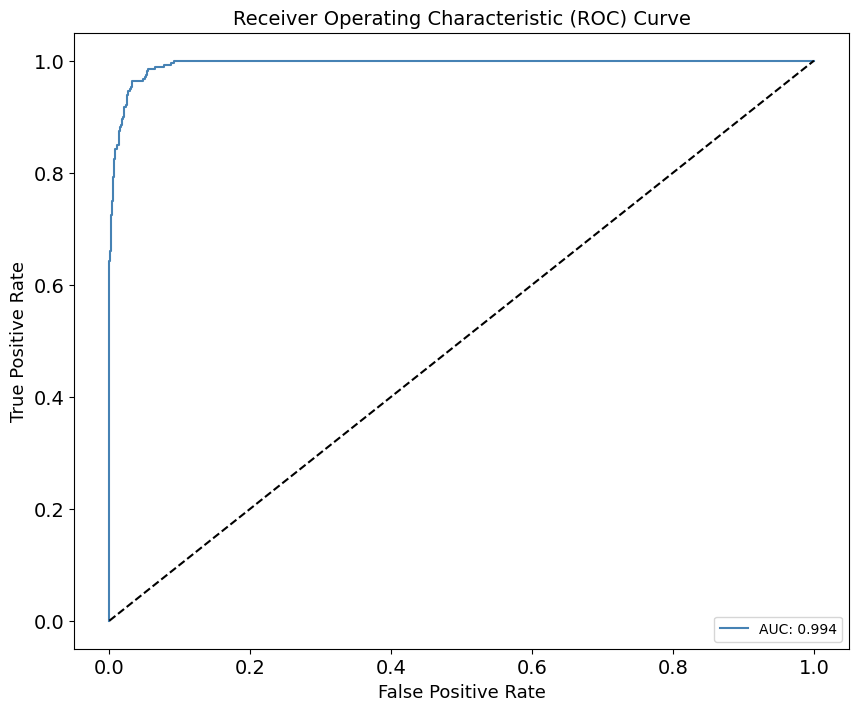

In [120]:
# Predict probabilities
y_probs = best_rf_model.predict_proba(X_valid)[:, 1]

# Compute ROC
fpr, tpr, _ = roc_curve(y_valid, y_probs)
auc_score = roc_auc_score(y_valid, y_probs)

# Plot ROC Curve
#Function for Plotting ROC Curve
def plot_roc_curve(fpr, tpr, auc):
    f, ax = plt.subplots(figsize=(10, 8))
    plt.plot(fpr, tpr, color='steelblue', label='ROC')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(['AUC: %.3f' % auc], fontsize=10)
#plt.show()
plot_roc_curve(fpr, tpr, auc_score)

# Report
print("Best Random Forest AUC Score:", round(auc_score, 4))
print("Best Hyperparameters:", grid_search.best_params_)
